In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from dms_3d_features.plotting import plot_pop_avg_from_row, publication_style_ax, plot_motif_boxplot_stripplot
from dms_3d_features.pdb_features import compute_solvent_accessibility_all



In [2]:
def r2(x, y):
    return pearsonr(x, y)[0] ** 2

In [3]:
DATA_PATH = "../data"

In [4]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df = df[df["has_pdbs"] == True]
df.drop(columns=["has_pdbs", "pdb_path", "n_pdbs"], inplace=True)
df["ln_r_data"] = np.log(df["r_data"])
df['ln_r_data'].replace(-np.inf, -9.8, inplace=True)


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_sasa = compute_solvent_accessibility_all(f"{DATA_PATH}/pdbs", 0.5)

FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: warning: Found no matches to resn 'C', typo?
FreeSASA: 

In [6]:
df_sasa.query("m_sequence == 'AAAC&GCU' and pdb_r_pos == 4")

,pdb,m_sequence,r_nuc,pdb_r_pos,sasa
2,../data/pdbs/AAAC_GCU/TWOWAY.6NY2.1-2.GCU-AAAC...,AAAC&GCU,A,4,2.835643


In [7]:
df_sasa.query("m_sequence == 'AAAC&GCU' and pdb_r_pos == 4").iloc[0]["pdb"]

'../data/pdbs/AAAC_GCU/TWOWAY.6NY2.1-2.GCU-AAAC.0.pdb'

In [8]:
df_merge = df_sasa.merge(df, on=["m_sequence", "pdb_r_pos", "r_nuc"])

In [9]:
df_merge.iloc[0]

pdb                     ../data/pdbs/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-AC...
m_sequence                                                      ACCC&GACU
r_nuc                                                                   A
pdb_r_pos                                                               3
sasa                                                              5.37142
both_purine                                                         False
both_pyrimidine                                                      True
constructs                                                   construct787
likely_pair                                                            AU
m_flank_bp_5p                                                          AU
m_flank_bp_3p                                                          CG
m_orientation                                                 non-flipped
m_pos                                                                   5
m_second_flank_bp_5p                  

<Axes: xlabel='sasa', ylabel='r_type'>

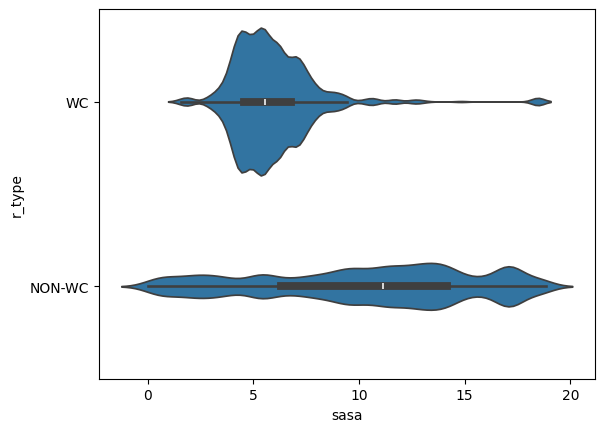

In [10]:
sns.violinplot(data=df_merge, x="sasa", y="r_type")

In [11]:
r2(df_merge["sasa"], df_merge["ln_r_data"])

0.2061062137666421

In [12]:
df_non_wc = df_merge.query("r_type == 'NON-WC'").copy()
df_wc = df_merge.query("r_type == 'WC'").copy()

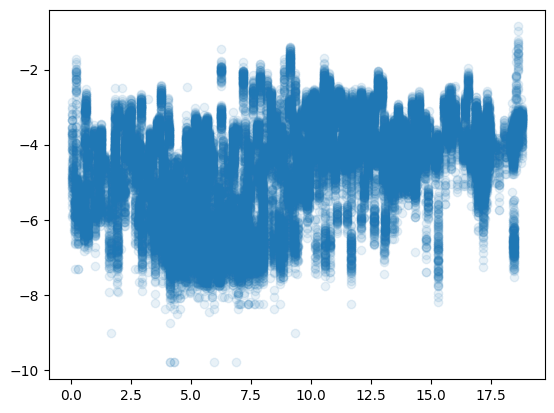

In [13]:
plt.scatter(df_merge["sasa"], df_merge["ln_r_data"], alpha=0.1)

In [14]:
data = [] 
for i, group in df_merge.groupby(["m_sequence", "r_loc_pos"]):
    data.append([group["r_data"].mean(), group["sasa"].mean()])
df_avg = pd.DataFrame(data, columns=["r_data", "sasa"])
df_avg["ln_r_data"] = np.log(df_avg["r_data"])
df_avg['ln_r_data'].replace(-np.inf, -9.8, inplace=True)


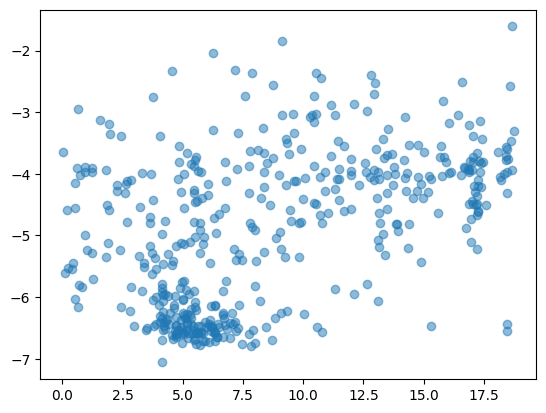

In [15]:
plt.scatter(df_avg["sasa"], df_avg["ln_r_data"], alpha=0.5)

In [16]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-C' and r_nuc == 'C'").copy()
for i, group in df_sub.groupby("pdb"):
    print(i, group["sasa"].mean(), group["r_data"].mean())

../data/pdbs/ACG_CAU/TWOWAY.4M4O.1-1.ACG-CAU.0.pdb 8.261546400735012 0.012318857142857142
../data/pdbs/CCC_GAG/TWOWAY.6IA2.1-1.CCC-GAG.0.pdb 0.6611572485591074 0.0021200000000000004
../data/pdbs/CCG_UAG/TWOWAY.5ZTM.1-1.UAG-CCG.0.pdb 12.091864633894009 0.002606521739130435
../data/pdbs/GAA_UCC/TWOWAY.4P95.1-1.GAA-UCC.0.pdb 3.745279999625864 0.003903823529411765
../data/pdbs/GAA_UCC/TWOWAY.5XYI.1-1.GAA-UCC.0.pdb 4.00439715208354 0.003903823529411765
../data/pdbs/GAC_GCC/TWOWAY.6OL3.1-1.GAC-GCC.0.pdb 4.265970501684751 0.0025987179487179488


In [17]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-C' and r_nuc == 'A'").copy()
for i, group in df_sub.groupby("pdb"):
    print(i, group["sasa"].mean(), group["r_data"].mean())

../data/pdbs/AAC_GCU/TWOWAY.5XXU.1-1.GCU-AAC.0.pdb 1.0816312126088583 0.005071500000000001
../data/pdbs/AAC_GCU/TWOWAY.7JQC.1-1.AAC-GCU.0.pdb 1.396103232332853 0.005071500000000001
../data/pdbs/AAU_ACU/TWOWAY.1Z7F.1-1.AAU-ACU.0.pdb 1.1803354361316467 0.004771707317073171
../data/pdbs/AAU_ACU/TWOWAY.1Z7F.1-1.ACU-AAU.0.pdb 1.694662847297018 0.004771707317073171
../data/pdbs/AAU_ACU/TWOWAY.5CCB.1-1.ACU-AAU.0.pdb 2.2000347203790267 0.004771707317073171
../data/pdbs/AAU_ACU/TWOWAY.5D0B.1-1.ACU-AAU.0.pdb 2.2603974462897973 0.004771707317073171
../data/pdbs/CAC_GCG/TWOWAY.6AGB.1-1.CAC-GCG.0.pdb 2.088890040564593 0.006000909090909092
../data/pdbs/CAC_GCG/TWOWAY.6AH3.1-1.CAC-GCG.0.pdb 1.6960017971788721 0.006000909090909092
../data/pdbs/GAA_UCC/TWOWAY.4P95.1-1.GAA-UCC.0.pdb 0.012524551843730278 0.006828529411764706
../data/pdbs/GAA_UCC/TWOWAY.5XYI.1-1.GAA-UCC.0.pdb 1.8705337328277967 0.006828529411764706
../data/pdbs/GAC_GCC/TWOWAY.6OL3.1-1.GAC-GCC.0.pdb 0.4628683766649746 0.004330256410256411


In [18]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-A' and r_nuc == 'A'").copy()
for i, group in df_sub.groupby("pdb"):
    print(i, group["sasa"].mean(), group["r_data"].mean(), group["pdb_r_bp_type"].iloc[0])

../data/pdbs/AAC_GAU/TWOWAY.7LMA.1-1.GAU-AAC.0.pdb 2.6960398416821825 0.008435365853658536 cWW
../data/pdbs/AAG_CAU/NWAY.3HOY.1-0-0-0.AAG-DA-DC-DT.0.pdb 1.9536656747585732 0.010167272727272726 cWH
../data/pdbs/AAU_GAU/TWOWAY.6SWD.1-1.GAU-AAU.0.pdb 6.301587245722405 0.008967380952380952 cWW
../data/pdbs/CAA_UAG/TWOWAY.6N7R.1-1.UAG-CAA.0.pdb 2.604439433346815 0.013462093023255814 cWW
../data/pdbs/CAG_CAG/NWAY.3NJ7.4.CAGCAG.0.pdb 2.2470175239372785 0.013014583333333335 cWW
../data/pdbs/CAG_CAG/TWOWAY.3NJ7.1-1.CAG-CAG.0.pdb 12.98471420809957 0.013014583333333335 cWW
../data/pdbs/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.0.pdb 2.4474850663562195 0.013014583333333335 cWW
../data/pdbs/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.1.pdb 11.95171451363565 0.013014583333333335 cWW
../data/pdbs/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.2.pdb 0.6860692437623573 0.013014583333333335 cWW
../data/pdbs/CAG_UAG/TWOWAY.5UNE.1-1.CAG-UAG.0.pdb 0.19342461300643157 0.09783850000000001 cWW
../data/pdbs/CAG_UAG/TWOWAY.5UNE.1-1.UAG-CAG.0.pdb 8

In [19]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'A-G' and r_nuc == 'A'").copy()
for i, group in df_sub.groupby("pdb"):
    print(i, group["sasa"].mean(), group["r_data"].mean(), group["pdb_r_bp_type"].iloc[0])

../data/pdbs/AAU_AGU/TWOWAY.2H1M.1-1.AAU-AGU.0.pdb 0.27799275384004735 0.002926976744186047 cHW
../data/pdbs/AAU_AGU/TWOWAY.2H1M.1-1.AGU-AAU.0.pdb 0.273277761209153 0.002926976744186047 cHW
../data/pdbs/AAU_AGU/TWOWAY.5XYI.1-1.AGU-AAU.0.pdb 0.14027256895225354 0.002926976744186047 cHW
../data/pdbs/AAU_AGU/TWOWAY.7LMA.1-1.AAU-AGU.0.pdb 2.6471888882889214 0.002926976744186047 cHW
../data/pdbs/CAA_UGG/TWOWAY.7LYF.1-1.UGG-CAA.0.pdb 5.840251173944097 0.0059071875 cWW
../data/pdbs/CAC_GGG/TWOWAY.3D0U.1-1.GGG-CAC.0.pdb 0.15238202884515598 0.003676 cWW
../data/pdbs/CAC_GGG/TWOWAY.3DIL.1-1.GGG-CAC.0.pdb 0.1069292268225898 0.003676 cWW
../data/pdbs/CAG_UGG/TWOWAY.3CUL.1-1.UGG-CAG.0.pdb 0.019580377422669 0.026122 cWW
../data/pdbs/GAC_GGC/TWOWAY.4M4O.1-1.GGC-GAC.0.pdb 0.24270756335380084 0.00395842105263158 cWW


In [20]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1' and pdb_r_pair == 'C-U' and r_nuc == 'C'").copy()
for i, group in df_sub.groupby("pdb"):
    print(i, group["sasa"].mean(), group["r_data"].mean(), group["pdb_r_bp_type"].iloc[0])

../data/pdbs/ACA_UUU/TWOWAY.5XYI.1-1.ACA-UUU.0.pdb 5.734666124004946 0.0073366666666666676 cWW
../data/pdbs/ACU_AUU/TWOWAY.6QKL.1-1.AUU-ACU.0.pdb 10.702216994526092 0.009334848484848484 cWW
../data/pdbs/CCC_GUG/NWAY.3PO2.1-0-0-0.CCC-DG-DG-DT.0.pdb 2.1634547522707934 0.005887567567567567 cWW
../data/pdbs/CCC_GUG/NWAY.3PO3.1-0-0-0.CCC-DG-DG-DT.0.pdb 3.933190489234727 0.005887567567567567 cWW
../data/pdbs/CCC_GUG/NWAY.4BXX.1-0-0-0.CCC-DG-DG-DT.0.pdb 3.719580136942005 0.005887567567567567 cWW
../data/pdbs/CCC_GUG/TWOWAY.4JYA.1-1.CCC-GUG.0.pdb 10.327753938795128 0.005887567567567567 cWW
../data/pdbs/CCG_CUG/TWOWAY.3RW6.1-1.CCG-CUG.1.pdb 8.617628783782106 0.011069024390243903 cWW
../data/pdbs/CCG_UUG/TWOWAY.3J7A.1-1.UUG-CCG.0.pdb 9.038545031959922 0.007079 cWW
../data/pdbs/CCG_UUG/TWOWAY.6OKK.1-1.UUG-CCG.0.pdb 9.040921373949795 0.007079 cWW
../data/pdbs/GCC_GUC/TWOWAY.6YSI.1-1.GUC-GCC.0.pdb 9.900688157766126 0.008325 cWW
../data/pdbs/GUA_UCC/TWOWAY.6SPB.1-1.UCC-GUA.0.pdb 8.885501447832418 0.

In [21]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '2x2' and pdb_r_pair == 'A-C' and r_nuc == 'C'").copy()
for i, group in df_sub.groupby("pdb"):
    print(i, group["sasa"].mean(), group["r_data"].mean(), group["pdb_r_bp_type"].iloc[0])

../data/pdbs/ACCC_GACU/NWAY.3WBM.6.ACCCGACU.0.pdb 8.740709203939868 0.01057701030927835 cWW
../data/pdbs/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb 1.3843269976115242 0.01057701030927835 cWW
../data/pdbs/GACC_GACC/TWOWAY.1D4R.2-2.GACC-GACC.0.pdb 2.0440260870669995 0.0052099019607843135 cWW
../data/pdbs/GACC_GACC/TWOWAY.1D4R.2-2.GACC-GACC.1.pdb 3.636073061527319 0.0052099019607843135 cWW
../data/pdbs/GACC_GACC/TWOWAY.1JID.2-2.GACC-GACC.0.pdb 2.566562302920096 0.0052099019607843135 cWW
../data/pdbs/GACC_GACC/TWOWAY.1L9A.2-2.GACC-GACC.0.pdb 6.813009302104721 0.0052099019607843135 cWW
../data/pdbs/GACC_GACC/TWOWAY.1MFQ.2-2.GACC-GACC.0.pdb 5.16916035239676 0.0052099019607843135 cWW
../data/pdbs/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb 10.542434013936747 0.09488090000000002 cWW


In [22]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '2x2'").copy()
for i, group in df_sub.groupby("pdb"):
    print(i, group["sasa"].mean(), group["r_data"].mean(), group["r_nuc"].iloc[0], group["pdb_r_pair"].iloc[0], group["pdb_r_bp_type"].iloc[0])

../data/pdbs/AAAG_CGAU/TWOWAY.5O5J.2-2.AAAG-CGAU.0.pdb 10.451181795513126 0.037119845360824744 A A-A tSH
../data/pdbs/AAUA_UUCU/TWOWAY.6ZVI.2-2.AAUA-UUCU.0.pdb 16.97353021177549 0.006041683168316831 A - -
../data/pdbs/ACCC_GACU/NWAY.3WBM.6.ACCCGACU.0.pdb 7.830334892782493 0.016850824742268043 C C-C cWW
../data/pdbs/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb 2.7415351270004806 0.016850824742268043 C C-C cWW
../data/pdbs/AUCU_AUUU/TWOWAY.6FF4.2-2.AUCU-AUUU.0.pdb 6.659055195225554 0.002744489795918368 C C-U cWS
../data/pdbs/CCCG_CCCG/NWAY.5EW4.0-0-2.CG-CC-CCCG.0.pdb 4.817719974921001 0.01579557971014493 C C-C cWW
../data/pdbs/CCCG_CCCG/NWAY.5EW4.2-0-0.CCCG-CG-CC.0.pdb 4.878033287115644 0.01579557971014493 C C-C cWW
../data/pdbs/CCUG_CCUG/NWAY.4K27.-1--1--1-1-0.C-C-C-CUG-UG.0.pdb 7.115702620815441 0.0036323404255319144 C C-U cWW
../data/pdbs/CCUG_CCUG/NWAY.4K27.0-2-0.UG-CCUG-CC.0.pdb 2.854197702814015 0.0036323404255319144 C C-U cWW
../data/pdbs/CCUG_CCUG/TWOWAY.4K27.2-2.CCUG-CCUG.0.pdb 1.2

In [23]:
def create_heatmap(df, ln_r_data_col, sasa_col, bins=10):
    """
    Creates and displays a heatmap using the specified columns from the dataframe with binning.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    ln_r_data_col (str): The column name for ln_r_data.
    sasa_col (str): The column name for sasa.
    bins (int): The number of bins to use for binning the continuous data.
    """
    # Create bins for the continuous data
    df['ln_r_data_binned'] = pd.cut(df[ln_r_data_col], bins=bins)
    df['sasa_binned'] = pd.cut(df[sasa_col], bins=bins)
    
    # Create a pivot table
    pivot_table = df.pivot_table(index='ln_r_data_binned', columns='sasa_binned', aggfunc='size', fill_value=0)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='d')
    plt.title('Heatmap of ln_r_data vs sasa')
    plt.xlabel(sasa_col)
    plt.ylabel(ln_r_data_col)
    plt.show()


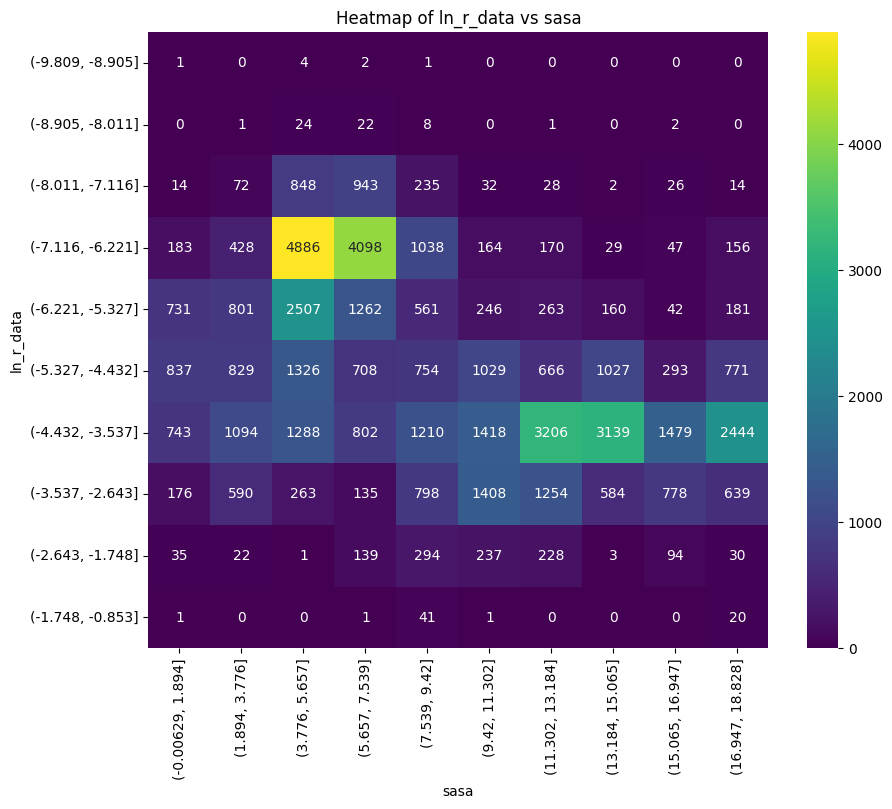

In [24]:
create_heatmap(df_merge, 'ln_r_data', 'sasa', bins=10)

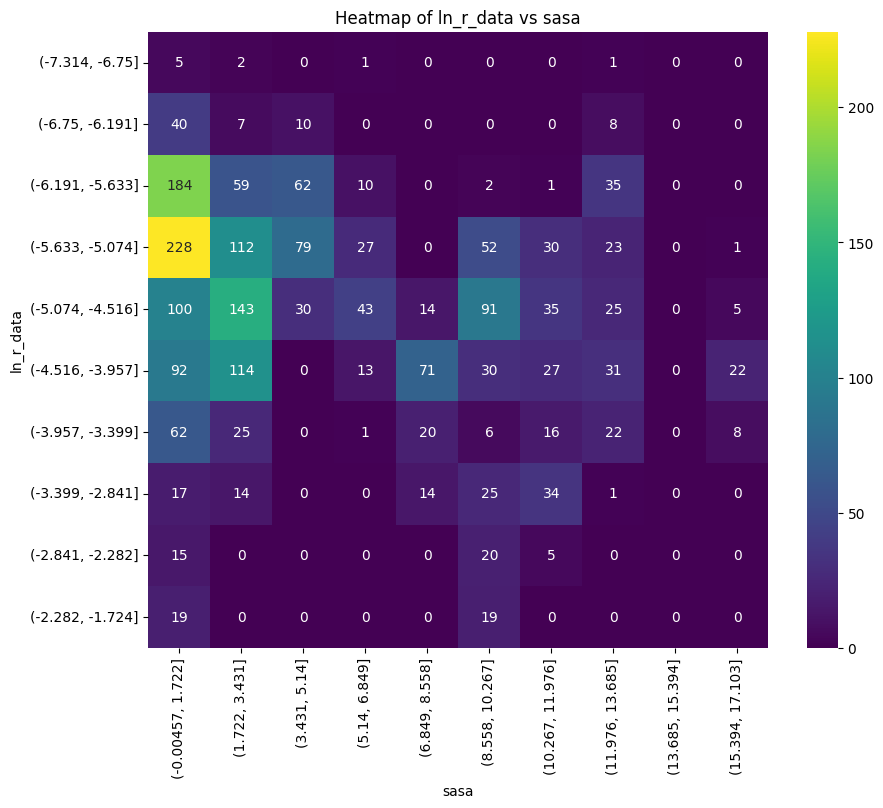

In [25]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '1x1'").copy()
create_heatmap(df_sub, 'ln_r_data', 'sasa', bins=10)

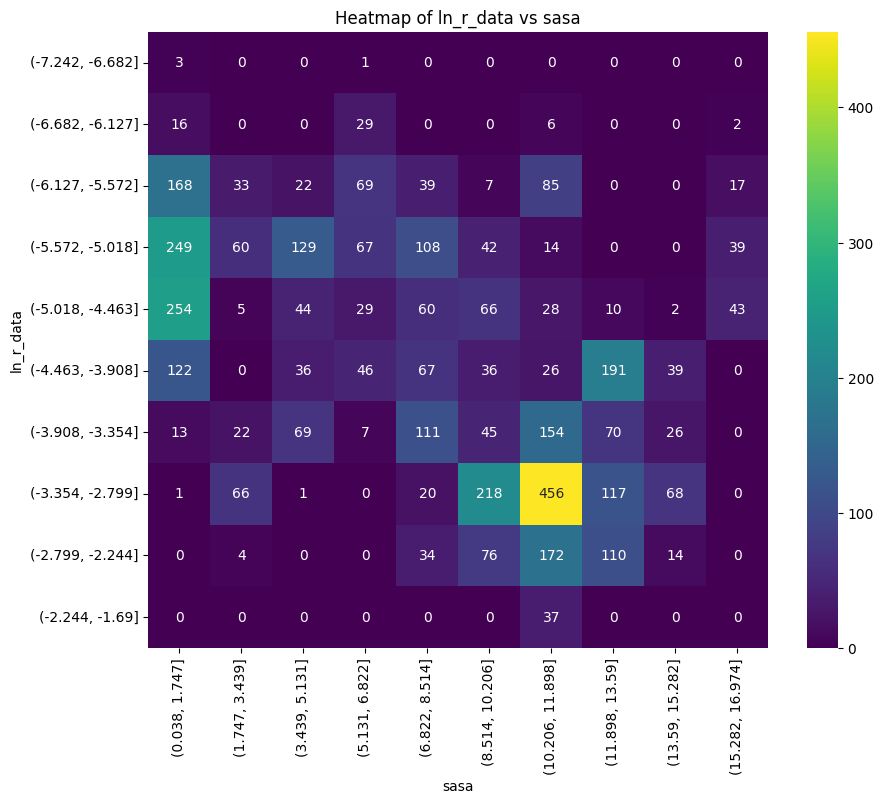

In [26]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '2x2'").copy()
create_heatmap(df_sub, 'ln_r_data', 'sasa', bins=10)

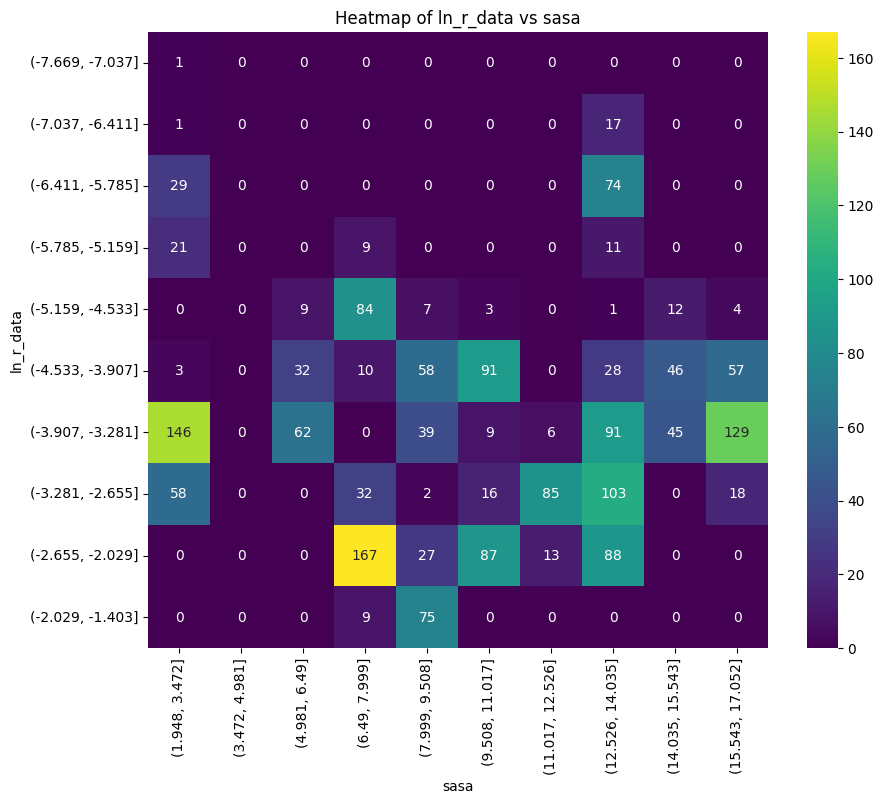

In [27]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '3x3'").copy()
create_heatmap(df_sub, 'ln_r_data', 'sasa', bins=10)

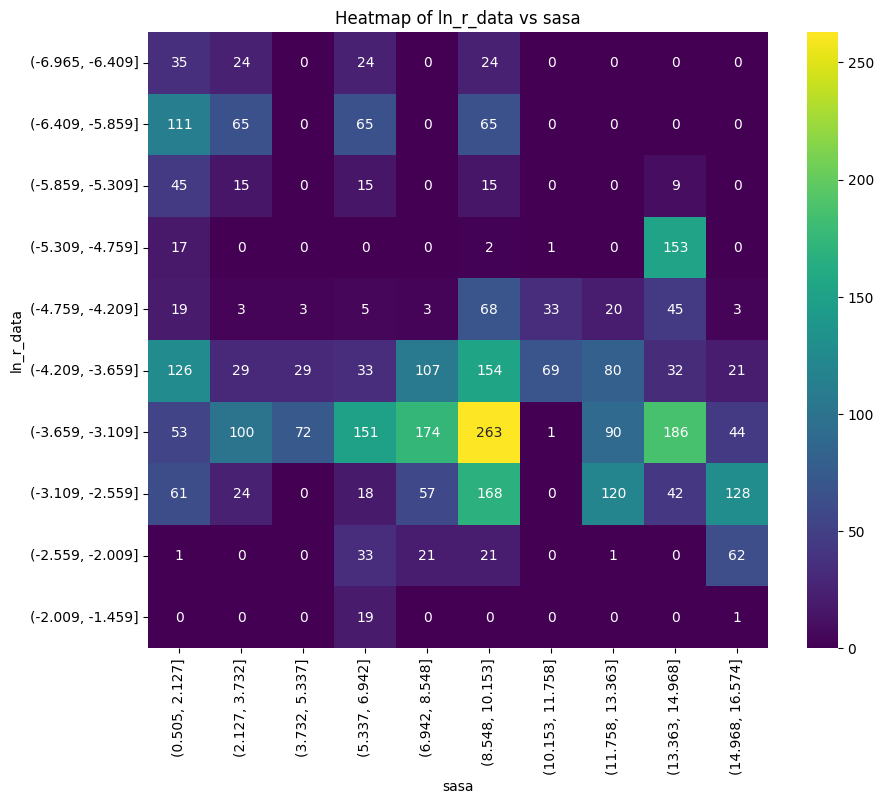

In [28]:
df_sub = df_merge.query("r_type == 'NON-WC' and m_token == '4x4'").copy()
create_heatmap(df_sub, 'ln_r_data', 'sasa', bins=10)

<Axes: xlabel='sasa', ylabel='m_token'>

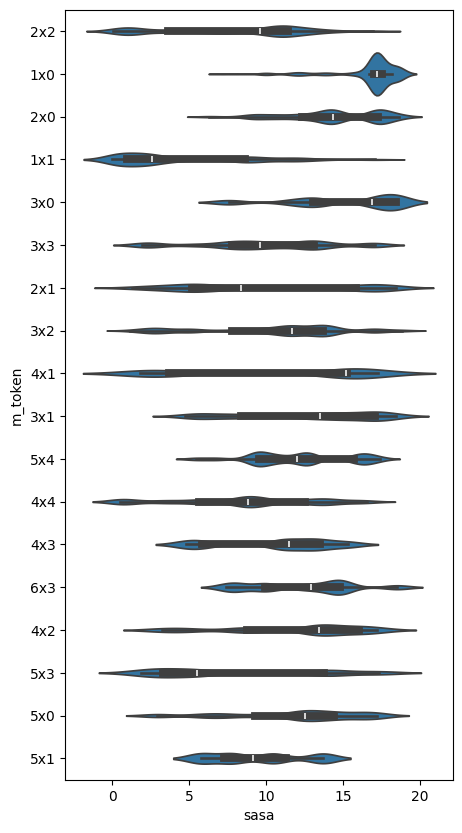

In [35]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(data=df_non_wc, x="sasa", y="m_token", width=1.0, ax=ax)

<Axes: xlabel='sasa', ylabel='likely_pair'>

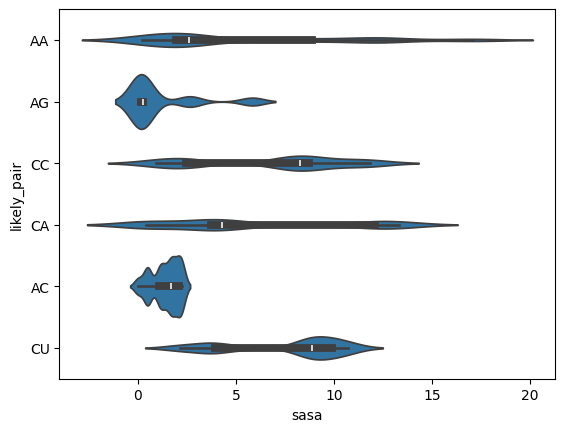

In [39]:
df_sub = df_non_wc.query("m_token == '1x1'").copy()
sns.violinplot(data=df_sub, x="sasa", y="likely_pair", width=1.0)

<Axes: xlabel='ln_r_data', ylabel='likely_pair'>

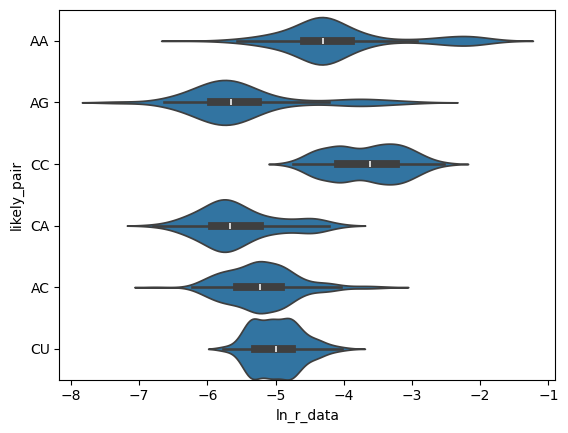

In [43]:
df_sub = df_non_wc.query("m_token == '1x1'").copy()
sns.violinplot(data=df_sub, x="ln_r_data", y="likely_pair", width=1.0)

<Axes: xlabel='sasa', ylabel='likely_pair'>

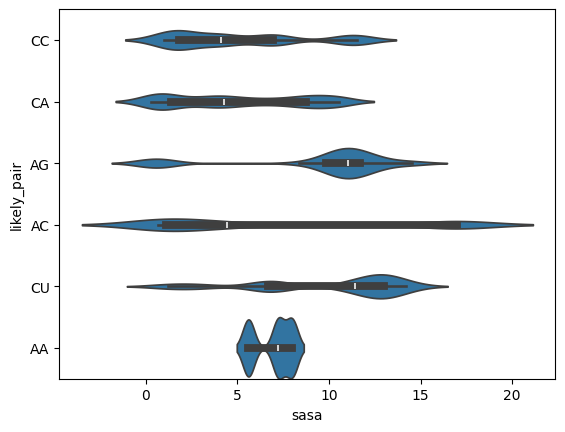

In [40]:
df_sub = df_non_wc.query("m_token == '2x2'").copy()
sns.violinplot(data=df_sub, x="sasa", y="likely_pair", width=1.0)

<Axes: xlabel='ln_r_data', ylabel='likely_pair'>

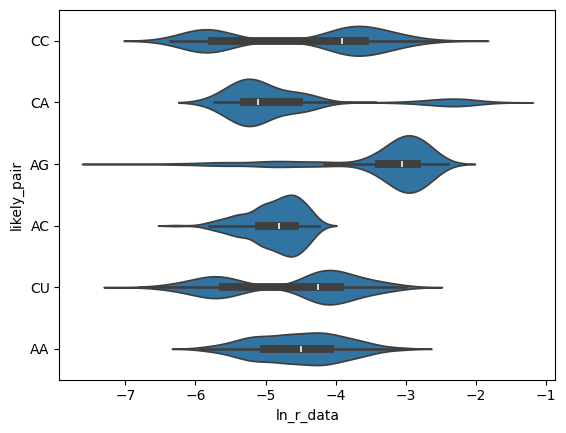

In [44]:
df_sub = df_non_wc.query("m_token == '2x2'").copy()
sns.violinplot(data=df_sub, x="ln_r_data", y="likely_pair", width=1.0)

<Axes: xlabel='sasa', ylabel='likely_pair'>

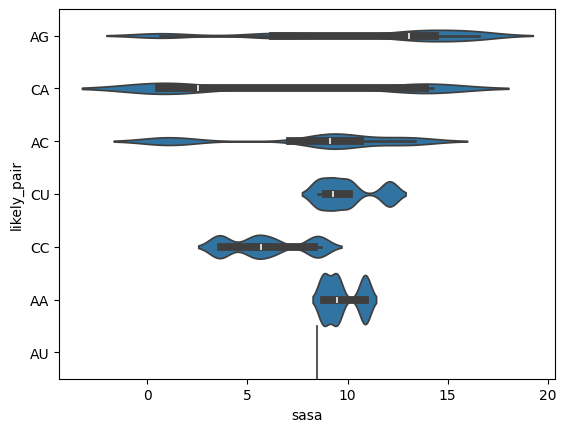

In [42]:
df_sub = df_non_wc.query("m_token == '4x4'").copy()
sns.violinplot(data=df_sub, x="sasa", y="likely_pair", width=1.0)

<Axes: xlabel='ln_r_data', ylabel='likely_pair'>

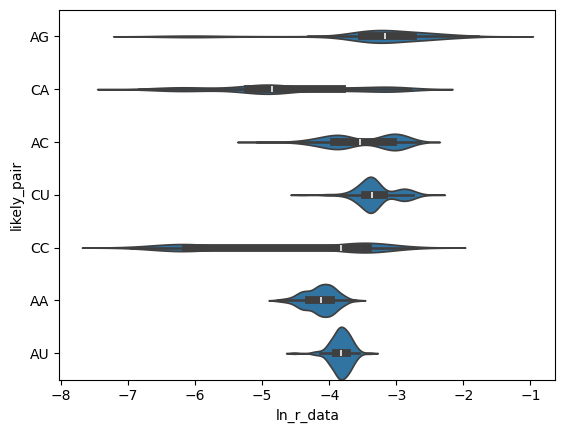

In [45]:
df_sub = df_non_wc.query("m_token == '4x4'").copy()
sns.violinplot(data=df_sub, x="ln_r_data", y="likely_pair", width=1.0)